# Projet GouvImmo, partie 5: Modèle de régression finale

### Introduction:

Ce notebook à pour but d'effectuer le modèle de régression finale, dans le cadre du projet fil rouge "GouvImmo" chez Datascientest. Différents modèles et Différentes approches ont été préalablement testé dans le but d'obtenir les meilleurs résultats possibles, et sont compilés dans les notebooks de test gouvimmo_project_part5_GBR, gouvimmo_project_part5_LR et gouvimmo_project_part5_PrixM2. Une première phase de modélisation avait été conduite, et les test ont été rassemblés dans les notebooks gouvimmo_project_part4_Lasso, gouvimmo_project_part4_LinearRegression et gouvimmo_project_part4_Ridge. Ce notebook est dédié à la construction du modèle finale, en appliquant les opérations qui se sont montrés les plus efficaces parmis tous les notebooks de test. 

### Jeu de données:

Les données ont été préalablement importés, fusionnées puis triées dans les notebook nommés gouvimmo_project_part1, gouvimmo_project_part2 et gouvimmo_project_part3 et sauvegardés dans un fichier csv nommé IDF_2019_to_2021_v3.csv

Le dataframe comporte les données de ventes immobilières de la région Ile de France, de 2019 à 2021. Il comporte des variables relatives à la localisation du bien, au type de bien vendu, à sa valeur et à ses carractéristiques (surface, nombre de pièces, nombre de dépendances, ...). 

Le but du modèle de régression est de déterminer la variable cible "Valeur foncière".

# Importation des librairies et du fichier de données en csv:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.pandas.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest
import geopandas as gpd
import contextily as cx

In [2]:
df=pd.read_csv("IDF_2019_to_2021_v3.csv")
df.head()

id_mutation  valeur_fonciere date_mutation  numero_disposition  \
0  2019-1135463         310000.0    2019-01-03                 1.0   
1  2019-1135466         155000.0    2019-01-04                 1.0   
2  2019-1135467         165500.0    2019-01-09                 1.0   
3  2019-1135468         269000.0    2019-01-02                 1.0   
4  2019-1135469         199500.0    2019-01-08                 1.0   

  nature_mutation  adresse_numero adresse_suffixe  \
0           Vente            11.0             NaN   
1           Vente             4.0             NaN   
2           Vente            45.0             NaN   
3           Vente             6.0             NaN   
4           Vente             3.0             NaN   

              adresse_nom_voie adresse_code_voie  code_postal  code_commune  \
0           RUE DE LA FONTAINE              0650      77220.0         77215   
1                AV DE LA GARE              0600      77340.0         77373   
2  RUE LOUIS VICTOR DE BROGLIE              1413      77176.0         77445   
3              RUE JEAN FERRAT              0492      77310.0         77407   
4           RUE DE LA PICARDIE              0186      77720.0         77211   

                 nom_commune  code_departement     id_parcelle  nombre_lots  \
0       Gretz-Armainvilliers                77  772150000B0473            0   
1          Pontault-Combault                77  77373000AD0157            2   
2          Savigny-le-Temple                77  77445000YA0444            3   
3   Saint-Fargeau-Ponthierry                77  77407000AY0353            0   
4  Grandpuits-Bailly-Carrois                77  772110170D0147            0   

   surface_reelle_bati  nombre_pieces_principales  surface_terrain  longitude  \
0                101.0                        4.0            855.0   2.740574   
1                 51.0                        2.0              0.0   2.616840   
2                 64.0                        3.0             12.0   2.565832   
3                 84.0                        4.0            270.0   2.553743   
4                109.0                        5.0           1036.0   2.993174   

    latitude  Appartement  Dépendance  Maison  terrains_a_batir  \
0  48.739669            0           0       1                 0   
1  48.805639            1           1       0                 0   
2  48.605740            1           2       0                 0   
3  48.530118            0           0       1                 0   
4  48.576719            0           0       1                 0   

   terrains_autre  prix_m² section_cadastrale  prix_m²_moy_ca  prix_m²_moy_co  \
0               1  3069.31         772150000B     3646.883495     3474.511880   
1               0  3039.22         77373000AD     3804.018010     3759.720085   
2               0  2585.94         77445000YA     2821.665116     2610.471778   
3               2  3202.38         77407000AY     2815.332174     2679.428891   
4               2  1830.28         772110170D     2360.692500     2020.605714   

   annee  code_annee    type_bien  
0   2019           0       Maison  
1   2019           0  Appartement  
2   2019           0  Appartement  
3   2019           0       Maison  
4   2019           0       Maison

# Preprocessing:

Ref: notebook gouvimmo_project_part5_GBR:

On commence par analyser la répartition des prix au m² selon la localisation:

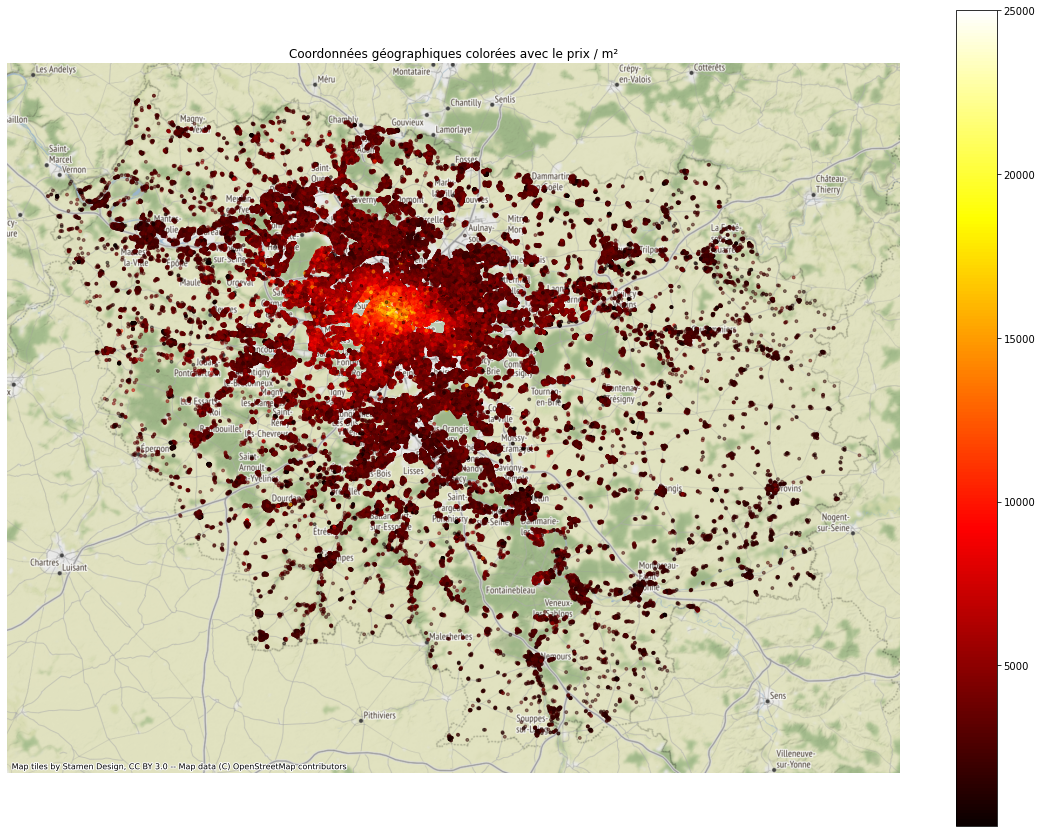

In [172]:
#Création d'un geodataframe avec les prix / m² et les coordonnées géographiques
geo=gpd.GeoDataFrame(df[["prix_m²", "longitude", "latitude"]], geometry=gpd.points_from_xy(df["longitude"], df["latitude"])).drop(["longitude", "latitude"], axis=1)

#Conversion du format EPSG
geo.crs = "EPSG:4326"
geo_wm=geo.to_crs(epsg=3857)

#Répartition des ventes, colorées selon le prix / m², dans la région Ile de France:
fig, ax = plt.subplots(figsize=(20, 15))
geo_wm.plot(alpha=0.5, column="prix_m²", markersize=8, ax=ax, legend=True, cmap="hot")
plt.title("Coordonnées géographiques colorées avec le prix / m²")
plt.axis('off')
cx.add_basemap(ax)

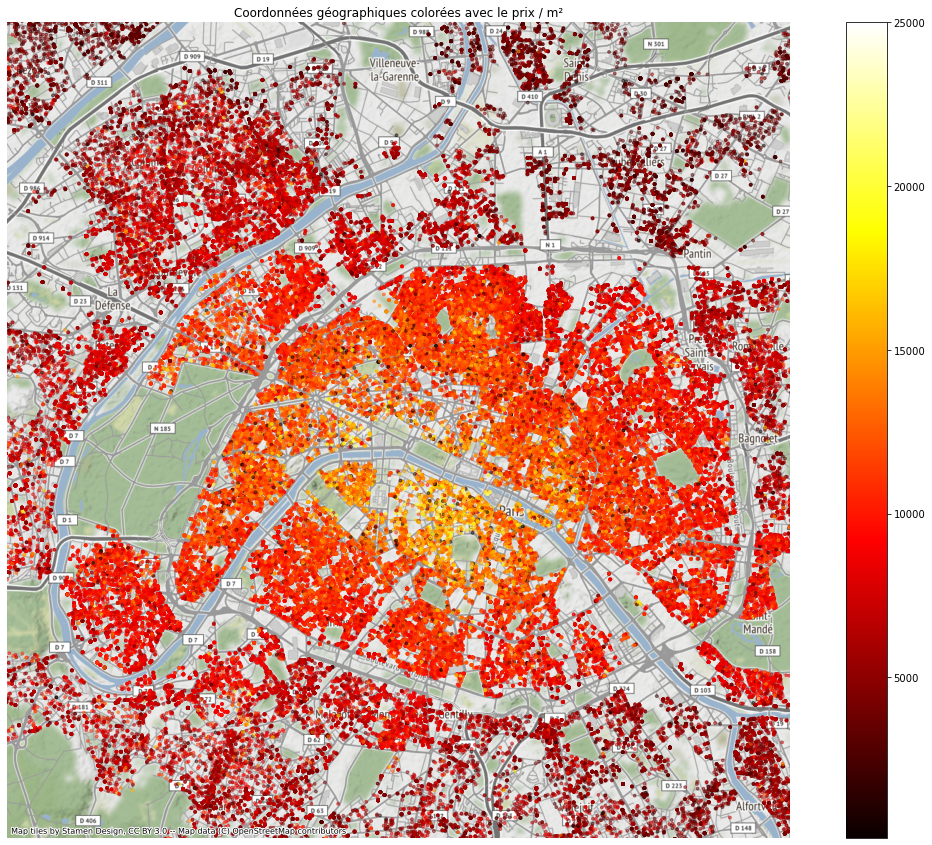

In [173]:
#Répartition des ventes, colorées selon le prix / m², zoom sur Paris:
fig, ax = plt.subplots(figsize=(20, 15))
geo_wm.plot(alpha=0.5, column="prix_m²", markersize=8, ax=ax, legend=True, cmap="hot")
plt.title("Coordonnées géographiques colorées avec le prix / m²")
plt.axis('off')
minx, miny, maxx, maxy = np.array([246000 ,   6240000,   270000,  6265000])
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
cx.add_basemap(ax)

On remarque que le centre de Paris compte les prix / m² les plus élevés, et que ceux ci semblent redescendre à mesure qu'on s'éloigne de ce centre. Pour aider le modèle de régression, on pourrait donc déterminer la position du point centrale, ou les prix / m² sont les plus hauts, et ajouter une variable distance par rapport à ce point centrale. Les essais effectués dans le notebook gouvimmo_project_part5_GBR ont démontrés que cette variable permettait d'améliorer la performance du modèle.

La position exacte de ce point centrale est difficile à déterminer avec précision, mais il semble que l'hotel matignon soit un point ou les prix sont très élevés sur la carte. Les coordonées géographiques de ce point sont 48.854167 N ; 2.320833 E.

Nous allons créer une variable qui calculera la distance euclidienne en Km par raport à ce point, pour chaque ventes. La formule mathématique est la suivante (avec lat1, lon1: les coordonnées du premier point et lat2, lon2: les coordonnées du second point):

ACOS(SIN(RADIANS(lat1))*SIN(RADIANS(lat2))+COS(RADIANS(lat1))*COS(RA DIANS(lat2))*COS(RADIANS(lon1-lon1)))*6371

### Création de la variable distance_centre

In [23]:
#Coordonnées du point centrale:
latC=48.854167
lonC=2.320833

#Calcul de distance
df["distance_centre"]=np.arccos(np.sin(np.radians(df["latitude"]))*np.sin(np.radians(latC))+np.cos(np.radians(df["latitude"]))*np.cos(np.radians(latC))*np.cos(np.radians(df["longitude"]-lonC)))*6371
df.head()

id_mutation  valeur_fonciere date_mutation  numero_disposition  \
0  2019-1135463         310000.0    2019-01-03                 1.0   
1  2019-1135466         155000.0    2019-01-04                 1.0   
2  2019-1135467         165500.0    2019-01-09                 1.0   
3  2019-1135468         269000.0    2019-01-02                 1.0   
4  2019-1135469         199500.0    2019-01-08                 1.0   

  nature_mutation  adresse_numero adresse_suffixe  \
0           Vente            11.0             NaN   
1           Vente             4.0             NaN   
2           Vente            45.0             NaN   
3           Vente             6.0             NaN   
4           Vente             3.0             NaN   

              adresse_nom_voie adresse_code_voie  code_postal  code_commune  \
0           RUE DE LA FONTAINE              0650      77220.0         77215   
1                AV DE LA GARE              0600      77340.0         77373   
2  RUE LOUIS VICTOR DE BROGLIE              1413      77176.0         77445   
3              RUE JEAN FERRAT              0492      77310.0         77407   
4           RUE DE LA PICARDIE              0186      77720.0         77211   

                 nom_commune  code_departement     id_parcelle  nombre_lots  \
0       Gretz-Armainvilliers                77  772150000B0473            0   
1          Pontault-Combault                77  77373000AD0157            2   
2          Savigny-le-Temple                77  77445000YA0444            3   
3   Saint-Fargeau-Ponthierry                77  77407000AY0353            0   
4  Grandpuits-Bailly-Carrois                77  772110170D0147            0   

   surface_reelle_bati  nombre_pieces_principales  surface_terrain  longitude  \
0                101.0                        4.0            855.0   2.740574   
1                 51.0                        2.0              0.0   2.616840   
2                 64.0                        3.0             12.0   2.565832   
3                 84.0                        4.0            270.0   2.553743   
4                109.0                        5.0           1036.0   2.993174   

    latitude  Appartement  Dépendance  Maison  terrains_a_batir  \
0  48.739669            0           0       1                 0   
1  48.805639            1           1       0                 0   
2  48.605740            1           2       0                 0   
3  48.530118            0           0       1                 0   
4  48.576719            0           0       1                 0   

   terrains_autre  prix_m² section_cadastrale  prix_m²_moy_ca  prix_m²_moy_co  \
0               1  3069.31         772150000B     3646.883495     3474.511880   
1               0  3039.22         77373000AD     3804.018010     3759.720085   
2               0  2585.94         77445000YA     2821.665116     2610.471778   
3               2  3202.38         77407000AY     2815.332174     2679.428891   
4               2  1830.28         772110170D     2360.692500     2020.605714   

   annee  code_annee    type_bien                  geometry  distance_centre  
0   2019           0       Maison  POINT (2.74057 48.73967)        33.276740  
1   2019           0  Appartement  POINT (2.61684 48.80564)        22.329285  
2   2019           0  Appartement  POINT (2.56583 48.60574)        32.954140  
3   2019           0       Maison  POINT (2.55374 48.53012)        39.882405  
4   2019           0       Maison  POINT (2.99317 48.57672)        58.179932

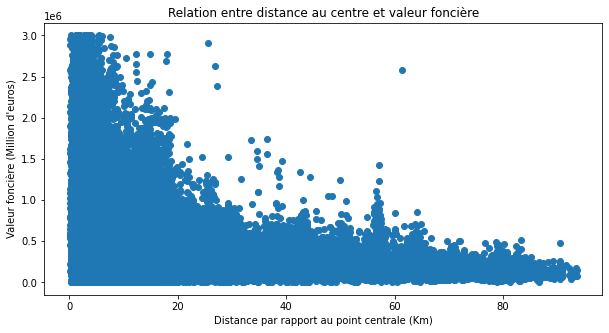

In [24]:
#Relation entre cette nouvelle variable et la variable cible:
plt.figure( figsize= (10, 5) )
plt.scatter(df["distance_centre"], df["valeur_fonciere"])
plt.title("Relation entre distance au centre et valeur foncière")
plt.xlabel("Distance par rapport au point centrale (Km)")
plt.ylabel("Valeur foncière (Million d'euros)");

La valeur foncière semble effectivement se réduire avec la distance.

### Préparation des données pour le modèle de régression:

Nous allons commencer par retirer les variables de prix au m² du dataset. En effet, ces variables ont été créées à partire de la variable cible, et ne doivent donc pas êtres inclues dans le modèle de régression. Nous retirerons également les variables non numériques, qui ne peuvent pas êtres utilisées par le modèle. 

Les premiers essais avaient démontrés que la dichotomisation des codes départements permettaient d'améliorer le score du modèle. Ils ont également montré que les variables "numero_disposition", "adresse_numero", "annee", "code_annee" n'étaient pas retenues comme pertinentes (Ref: notebook gouvimmo_project_part4_Lasso). Nous allons donc les retirer. La variable code postal est également redondante avec le code commune, nous la retirons également. Enfin, nous appliquerons une standardisation des données. 

In [193]:
#Sélection des variables numériques de df pour le modèle de régression:
num_df=df.select_dtypes(include=['int','float', "uint8"]).dropna(axis = 0, how = 'any')

#Retrait des variables prix/m² et des variables avec les coefs les plus bas retenus par Lasso:
num_df=num_df.drop(["prix_m²_moy_ca",
                    "prix_m²_moy_co",
                    "prix_m²",
                    "numero_disposition",
                    "adresse_numero",
                    "code_annee", 
                    "annee", 
                    "code_postal"], axis=1)

#Définition d'une fonction de préparation des données pour le modèle de régression:
def preprocessing(df, scaler):
    #Séparation de la variable cible:
    target =df["valeur_fonciere"]
    data =df.drop("valeur_fonciere", axis=1)

    #Dichotomisation du code département:
    data=data.join(pd.get_dummies(data['code_departement'], prefix='dep')).drop("code_departement", axis=1)

    #Création des ensembles d'entrainement et de test:
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=256)

    #Standardisation des variables:
    X_train=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    return X_train, X_test, y_train, y_test
    
#préparation des données pour notre modèle:
scaler = StandardScaler()
X_train, X_test, y_train, y_test=preprocessing(num_df, scaler)

# Modèle de régression

Nous allons créer un modèle de régression de type GradientBoostingRegressor. En effet, ce modèle s'est également révélé être le modèle le plus efficace lors de la phase de test (Ref: notebook gouvimmo_project_part5_GBR).

Pour calculer la performances de nos modèles, nous allons définir une fonction qui renverra le score R², la MAE et la RMSE.

In [194]:
#Fonction de métriques du modèle:

def perf(model, X_train, X_test, y_train, y_test):
    pred_train =model.predict(X_train)
    pred_test = model.predict(X_test)

    print("Score train: ", model.score(X_train, y_train))
    print("Score test: ", model.score(X_test, y_test))
    print("\n")
    print("MAE train: ", mean_absolute_error(y_train, pred_train))
    print("MAE test: ", mean_absolute_error(y_test, pred_test))
    print("\n")
    print("RMSE train: ", np.sqrt(mean_squared_error(y_train, pred_train)))
    print("RMSE test: ", np.sqrt(mean_squared_error(y_test, pred_test))) 

### Recherche de meilleurs hyper paramètres:

Nous allons rechercher les meilleurs hyper paramètres pour notre modèle. Nous allons notemment jouer sur n_estimators et max_depth.

In [223]:
GBR=GradientBoostingRegressor()
parametres={"n_estimators":[50,200,300], "max_depth":[2, 4, 5]}

grid_clf = GridSearchCV(estimator=GBR, param_grid=parametres)
grille = grid_clf.fit(X_train, y_train)
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score', 'std_test_score']])

                                  params  mean_test_score  std_test_score
0   {'max_depth': 2, 'n_estimators': 50}         0.743222        0.002493
1  {'max_depth': 2, 'n_estimators': 200}         0.795187        0.003356
2  {'max_depth': 2, 'n_estimators': 300}         0.802373        0.003444
3   {'max_depth': 4, 'n_estimators': 50}         0.804768        0.003921
4  {'max_depth': 4, 'n_estimators': 200}         0.830137        0.004070
5  {'max_depth': 4, 'n_estimators': 300}         0.834413        0.003960
6   {'max_depth': 5, 'n_estimators': 50}         0.818677        0.004003
7  {'max_depth': 5, 'n_estimators': 200}         0.837132        0.003909
8  {'max_depth': 5, 'n_estimators': 300}         0.840409        0.003951


Les meilleurs paramètres sont 'max_depth': 5, 'n_estimators': 300. Nous allons réentrainer notre modèle avec ces paramètres.

In [224]:
GBR=GradientBoostingRegressor(n_estimators=300, max_depth=5)

GBR.fit(X_train, y_train)
perf(GBR, X_train, X_test, y_train, y_test)

Score train:  0.865730104688226
Score test:  0.8374972610143822


MAE train:  60709.85739154074
MAE test:  62844.02945995481


RMSE train:  107188.96811879585
RMSE test:  117397.29182911072


Nous notons un score sur l'ensemble de test inférieur d'environ 3% au score de l'ensemble d'entrainement, témoignant d'un léger overfitting. 

# Analyse détaillée des performances du modèle:

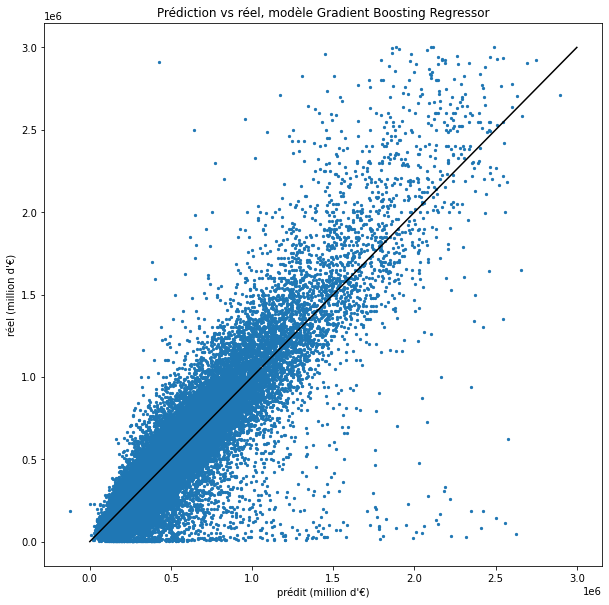

In [196]:
#Prédiction vs réel:
pred_test = GBR.predict(X_test)
plt.figure( figsize= (10, 10) )
plt.scatter(pred_test, y_test, s=5)
plt.plot([0, 3000000], [0, 3000000], c="black")
plt.xlabel("prédit (million d'€)")
plt.ylabel("réel (million d'€)")
plt.title("Prédiction vs réel, modèle Gradient Boosting Regressor");

Les prédictions semblent globalement s'aligner sur le réel, mais avec une forte dispersion. 

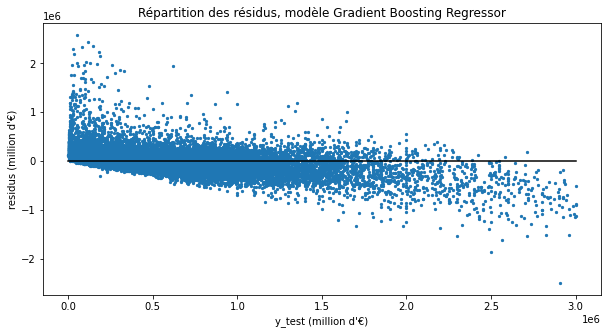

In [197]:
residus=pred_test-y_test
plt.figure( figsize= (10, 5) )
plt.scatter(y_test, residus, s=5)
plt.plot([0, max(y_test)], [0, 0], c="black")
plt.xlabel("y_test (million d'€)")
plt.ylabel("residus (million d'€)")
plt.title("Répartition des résidus, modèle Gradient Boosting Regressor");

La répartition des résidus révèle une tendance à surestimer les prix les plus bas et à sous estimer les prix les plus élevés. Le biais des résidus semblent proche de 0, sur un intervalle de 500 000€ à 1 000 000€. Au delas, les résidus montrent un biais de plus en plus important à mesure qu'on s'approche des extrèmes.

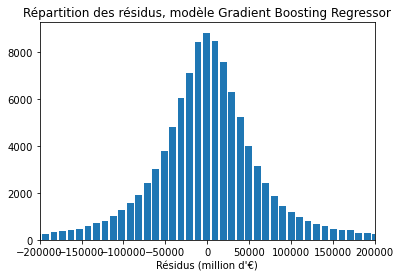

In [198]:
plt.hist(residus, bins=500, rwidth=0.8)
plt.xlim(-200000, 200000)
plt.title("Répartition des résidus, modèle Gradient Boosting Regressor")
plt.xlabel("Résidus (million d'€)");

In [199]:
residus.describe()

count    1.065090e+05
mean     1.523405e+02
std      1.174055e+05
min     -2.483747e+06
25%     -3.615144e+04
50%      1.235498e+01
75%      3.550543e+04
max      2.573293e+06
Name: valeur_fonciere, dtype: float64

Les résidus sont globalement centrés sur 0, avec la majorité des résidus compris entre plus ou moins 100 000€

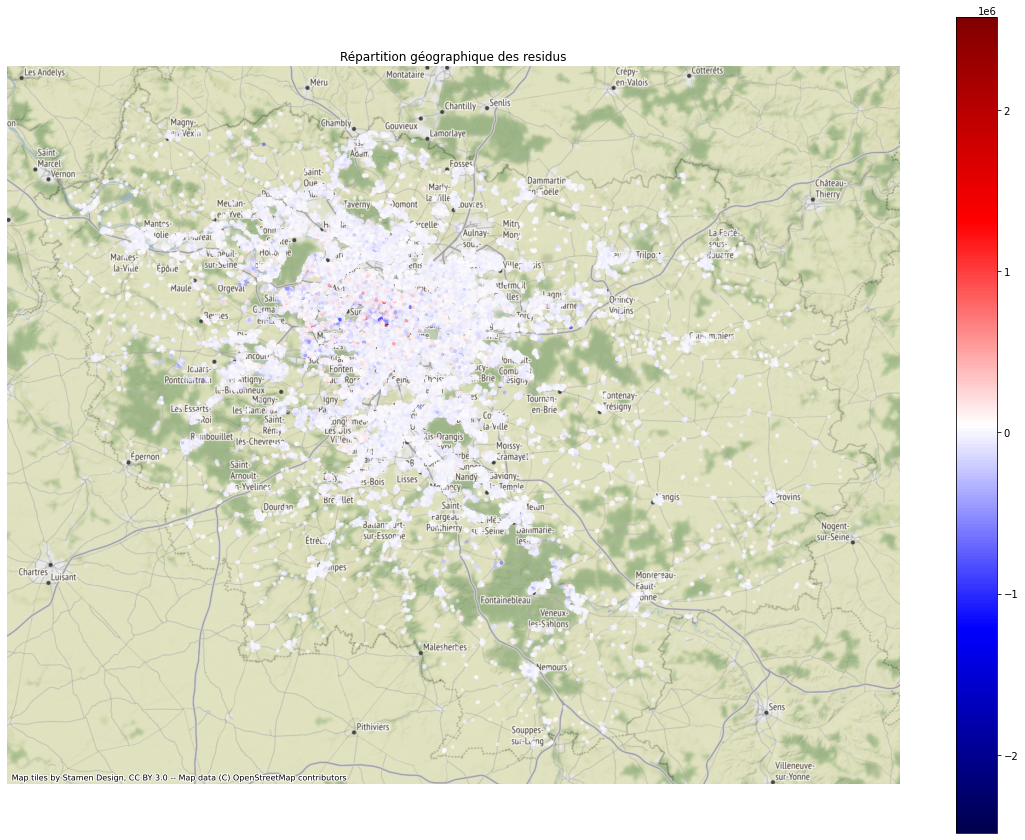

In [200]:
#Inversion de la standardisation ppour récupérer les coordonnées géo
revX_test=pd.DataFrame(scaler.inverse_transform(X_test), columns=X_test.columns)
revX_test["residus"]=residus.reset_index(drop=True)

#Création d'un geodataframe avec les coordonnées géographiques
geoXtest=gpd.GeoDataFrame(revX_test[["residus", "longitude", "latitude"]], geometry=gpd.points_from_xy(revX_test["longitude"], revX_test["latitude"])).drop(["longitude", "latitude"], axis=1)

#Conversion du format EPSG
geoXtest.crs = "EPSG:4326"
geoXtest_wm=geoXtest.to_crs(epsg=3857)

#Répartition des residus dans la région Ile de France:
fig, ax = plt.subplots(figsize=(20, 15))
geoXtest_wm.plot(alpha=0.5, column="residus", markersize=8, ax=ax, legend=True, cmap="seismic")
plt.title("Répartition géographique des residus")
plt.axis('off')
cx.add_basemap(ax)

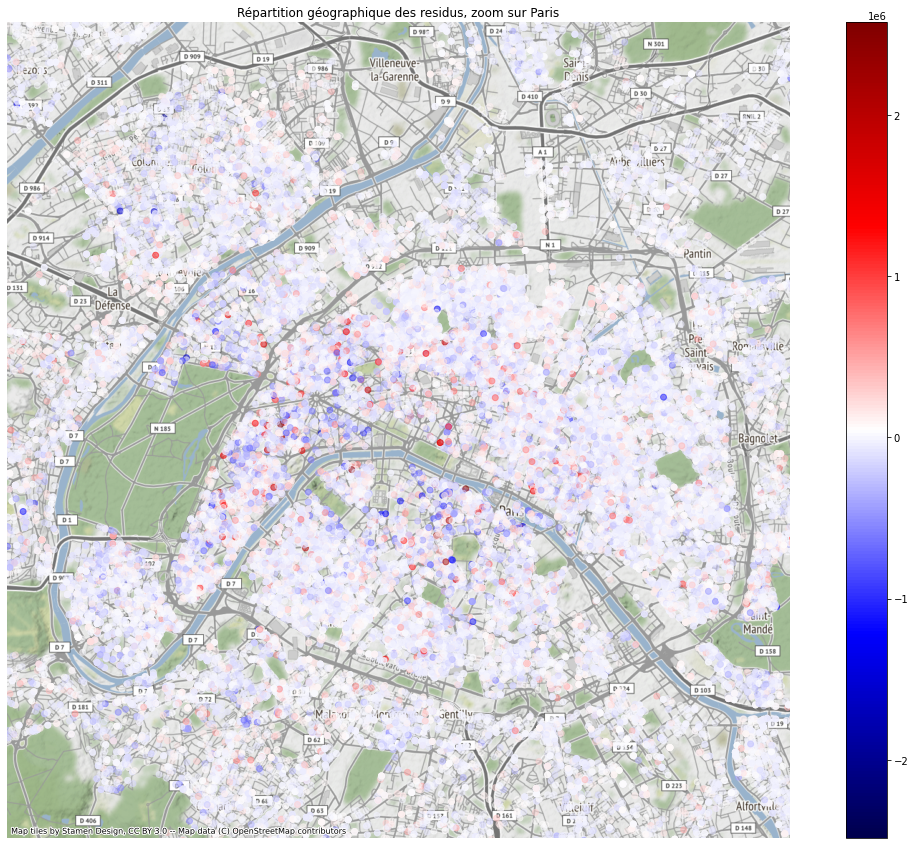

In [201]:
fig, ax = plt.subplots(figsize=(20, 15))
geoXtest_wm.plot(alpha=0.5, column="residus", ax=ax, legend=True, cmap="seismic")
plt.title("Répartition géographique des residus, zoom sur Paris")
plt.axis('off')
minx, miny, maxx, maxy = np.array([246000 ,   6240000,   270000,  6265000])
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
cx.add_basemap(ax)

On remarque sur ces graphiques que les résidus les plus élevés se concentrent dans la zone de Paris, là où les prix de ventes sont les plus élevés. Sur le reste de la région, les résidus semblent plus proche de 0. Le modèle fait donc des erreurs plus grandes sur la zone de Paris.

Nous allons étudier les données de la zone de Paris (département 75) et les comparer au reste des données, pour tenter de trouver une cause possible de ce taux d'erreur supérieur de cette zone. 

In [202]:
#On isole les données de Paris de celles du reste de la région:
df_75=df[df["code_departement"]==75]
df_no75=df[df["code_departement"]!=75]

print("Données du département 75 (Paris):")
display(df_75.describe())
print("Données des autres départements:")
display(df_no75.describe())

Données du département 75 (Paris):


valeur_fonciere  numero_disposition  adresse_numero   code_postal  \
count     7.300000e+04        73000.000000    72996.000000  73000.000000   
mean      5.525215e+05            1.002712       48.841115  75013.453932   
std       4.354805e+05            0.056066       73.383153      4.795692   
min       1.000000e+03            1.000000        1.000000  75001.000000   
25%       2.720000e+05            1.000000       11.000000  75011.000000   
50%       4.260000e+05            1.000000       27.000000  75015.000000   
75%       6.843000e+05            1.000000       66.000000  75017.000000   
max       3.000000e+06            5.000000     9003.000000  75020.000000   

       code_commune  code_departement   nombre_lots  surface_reelle_bati  \
count  73000.000000           73000.0  73000.000000         73000.000000   
mean   75113.453932              75.0      1.941274            52.070740   
std        4.795692               0.0      1.034225            34.542958   
min    75101.000000              75.0      0.000000             0.000000   
25%    75111.000000              75.0      1.000000            28.000000   
50%    75115.000000              75.0      2.000000            43.000000   
75%    75117.000000              75.0      2.000000            66.000000   
max    75120.000000              75.0     21.000000           300.000000   

       nombre_pieces_principales  surface_terrain     longitude      latitude  \
count               73000.000000     73000.000000  72967.000000  72967.000000   
mean                    2.384575         0.415836      2.340744     48.862322   
std                     1.221065        11.260466      0.037944      0.020171   
min                     0.000000         0.000000      2.255896     48.818759   
25%                     1.000000         0.000000      2.311749     48.845482   
50%                     2.000000         0.000000      2.343825     48.862903   
75%                     3.000000         0.000000      2.371850     48.880399   
max                    12.000000      1223.000000      2.412825     48.900565   

        Appartement    Dépendance        Maison  terrains_a_batir  \
count  73000.000000  73000.000000  73000.000000      73000.000000   
mean       0.996014      0.198863      0.003890          0.000096   
std        0.063012      0.445961      0.062252          0.009792   
min        0.000000      0.000000      0.000000          0.000000   
25%        1.000000      0.000000      0.000000          0.000000   
50%        1.000000      0.000000      0.000000          0.000000   
75%        1.000000      0.000000      0.000000          0.000000   
max        1.000000      2.000000      1.000000          1.000000   

       terrains_autre       prix_m²  prix_m²_moy_ca  prix_m²_moy_co  \
count    73000.000000  73000.000000    73000.000000    73000.000000   
mean         0.000260  10503.486109    10450.070180    10456.338189   
std          0.016131   3151.664890     1543.063440     1230.013272   
min          0.000000    100.000000     5347.313333     8689.112216   
25%          0.000000   8928.570000     9489.167170     9652.261865   
50%          0.000000  10476.190000    10317.763448    10314.249076   
75%          0.000000  12128.532500    11129.761714    10937.070987   
max          1.000000  25000.000000    23034.016667    14296.052839   

              annee    code_annee  distance_centre  
count  73000.000000  73000.000000     72967.000000  
mean    2019.756055      0.756055         3.727127  
std        0.761005      0.761005         1.337656  
min     2019.000000      0.000000         0.050601  
25%     2019.000000      0.000000         2.830101  
50%     2020.000000      1.000000         3.677032  
75%     2020.000000      1.000000         4.610210  
max     2021.000000      2.000000         6.884430

Données des autres départements:


valeur_fonciere  numero_disposition  adresse_numero    code_postal  \
count     2.914620e+05       291462.000000   283395.000000  291462.000000   
mean      2.965380e+05            1.007208      132.378119   88664.355346   
std       2.110630e+05            0.089981      907.648581    7166.422082   
min       5.000000e+02            1.000000        1.000000   75015.000000   
25%       1.670000e+05            1.000000        7.000000   78500.000000   
50%       2.450000e+05            1.000000       18.000000   92190.000000   
75%       3.540000e+05            1.000000       43.000000   94130.000000   
max       3.000000e+06            5.000000     9999.000000   95880.000000   

        code_commune  code_departement    nombre_lots  surface_reelle_bati  \
count  291462.000000     291462.000000  291462.000000        291462.000000   
mean    88536.490922         88.328592       1.572109            70.298903   
std      7109.168329          7.181370       1.363980            35.537904   
min     77001.000000         77.000000       0.000000             0.000000   
25%     78498.000000         78.000000       0.000000            47.000000   
50%     92024.000000         92.000000       2.000000            66.000000   
75%     94019.000000         94.000000       3.000000            88.000000   
max     95690.000000         95.000000      27.000000           300.000000   

       nombre_pieces_principales  surface_terrain      longitude  \
count              291462.000000    291462.000000  290062.000000   
mean                    3.245240       151.512290       2.356415   
std                     1.481002       282.935496       0.247477   
min                     0.000000         0.000000       1.453111   
25%                     2.000000         0.000000       2.219805   
50%                     3.000000         0.000000       2.341852   
75%                     4.000000       252.000000       2.497925   
max                    12.000000      2992.000000       3.517575   

            latitude    Appartement     Dépendance         Maison  \
count  290062.000000  291462.000000  291462.000000  291462.000000   
mean       48.826529       0.630291       0.494493       0.344477   
std         0.150121       0.482727       0.625551       0.475198   
min        48.133571       0.000000       0.000000       0.000000   
25%        48.761277       0.000000       0.000000       0.000000   
50%        48.843462       1.000000       0.000000       0.000000   
75%        48.925891       1.000000       1.000000       1.000000   
max        49.216561       1.000000       2.000000       1.000000   

       terrains_a_batir  terrains_autre        prix_m²  prix_m²_moy_ca  \
count     291462.000000   291462.000000  291462.000000   291462.000000   
mean           0.025231        0.070071    4239.582952     4255.346207   
std            0.156828        0.299476    2261.352951     2122.536830   
min            0.000000        0.000000     100.000000       74.986667   
25%            0.000000        0.000000    2775.000000     2979.645753   
50%            0.000000        0.000000    3708.330000     3679.811630   
75%            0.000000        0.000000    5238.100000     5260.380588   
max            1.000000        2.000000   24705.880000    77792.205625   

       prix_m²_moy_co          annee     code_annee  distance_centre  
count   291462.000000  291462.000000  291462.000000    290062.000000  
mean      4252.964392    2019.712851       0.712851        20.739043  
std       1749.221183       0.730111       0.730111        13.890381  
min        134.490000    2019.000000       0.000000         3.585493  
25%       3043.125729    2019.000000       0.000000        10.845699  
50%       3699.217132    2020.000000       1.000000        16.851863  
75%       5483.211384    2020.000000       1.000000        27.118326  
max      10861.266668    2021.000000       2.000000        93.613041

Nous remarquons que la valeur foncière et le prix au mètre carré est largement supérieur sur Paris que dans les autres départements. 

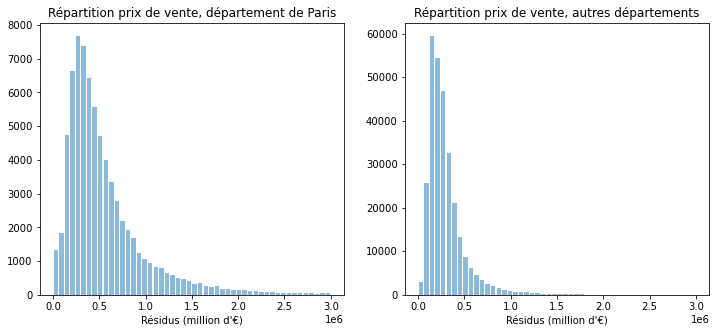

In [203]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(df_75["valeur_fonciere"], bins=50, rwidth=0.8, alpha=0.5)
plt.title("Répartition prix de vente, département de Paris")
plt.xlabel("Résidus (million d'€)")

plt.subplot(1, 2, 2)
plt.hist(df_no75["valeur_fonciere"], bins=50, rwidth=0.8, alpha=0.5)
plt.title("Répartition prix de vente, autres départements")
plt.xlabel("Résidus (million d'€)");

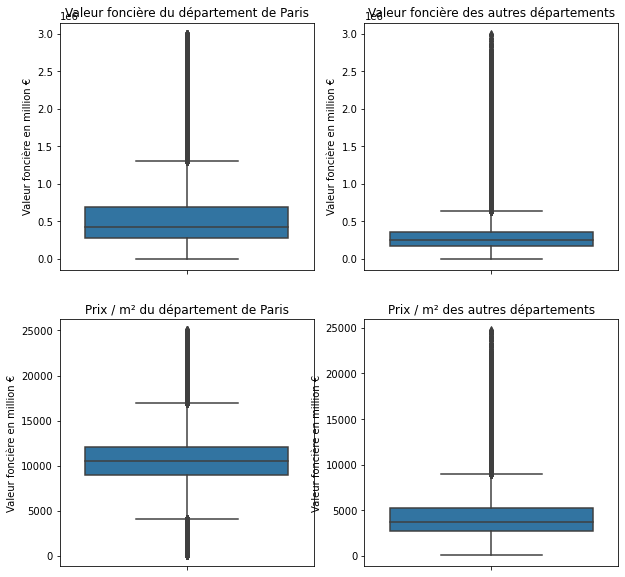

In [204]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1)
sns.boxplot(y=df_75["valeur_fonciere"])
plt.title("Valeur foncière du département de Paris")
plt.ylabel("Valeur foncière en million €")

plt.subplot(2, 2, 2)
sns.boxplot(y=df_no75["valeur_fonciere"])
plt.title("Valeur foncière des autres départements")
plt.ylabel("Valeur foncière en million €")

plt.subplot(2, 2, 3)
sns.boxplot(y=df_75["prix_m²"])
plt.title("Prix / m² du département de Paris")
plt.ylabel("Valeur foncière en million €")

plt.subplot(2, 2, 4)
sns.boxplot(y=df_no75["prix_m²"])
plt.title("Prix / m² des autres départements")
plt.ylabel("Valeur foncière en million €");

Les histogrammes et boites à moustaches montrent qu'il y a très peu de ventes supérieures à 1 000 000€ dans les autres départements que celui de Paris. En revanche, les ventes supérieures à 1 000 000€ représentent une part significative des ventes pour le département de Paris. Le prix / m² y est également bien plus élevé.

Nous avons vu précédemment que les prédictions du modèle montraient un biais important au delà de 1 000 000€. Cela pourrait donc expliquer les erreurs plus importantes dans la zone de Paris, où les prix de vente sont les plus élevés. De plus, la zone observable sur la carte, où la concentration d'erreurs est la plus importante semble correspondre à la zone où les prix / m² sont les plus élevés, observés sur la carte en début de ce notebook.

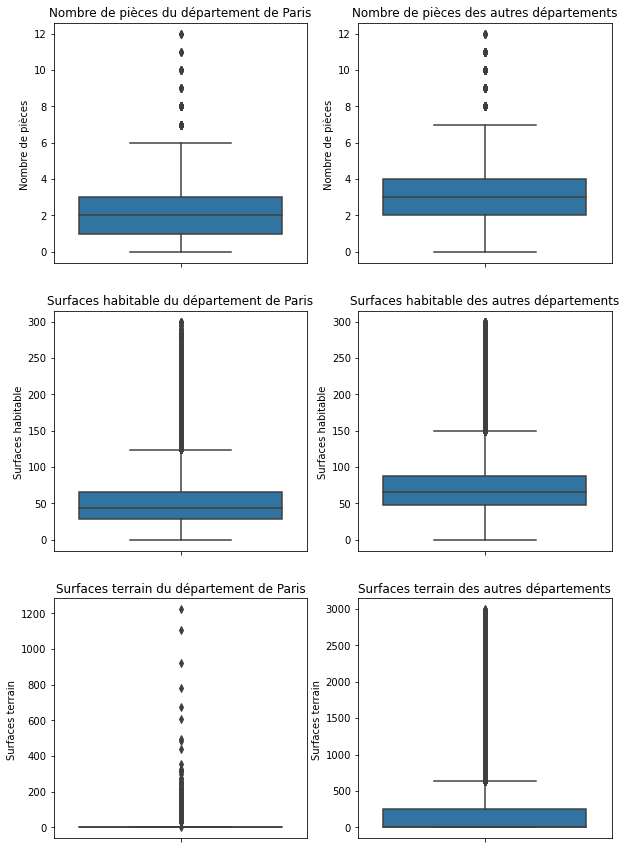

In [206]:
fig = plt.figure(figsize=(10,15))

plt.subplot(3, 2, 1)
sns.boxplot(y=df_75["nombre_pieces_principales"])
plt.title("Nombre de pièces du département de Paris")
plt.ylabel("Nombre de pièces ")

plt.subplot(3, 2, 2)
sns.boxplot(y=df_no75["nombre_pieces_principales"])
plt.title("Nombre de pièces des autres départements")
plt.ylabel("Nombre de pièces ")

plt.subplot(3, 2, 3)
sns.boxplot(y=df_75["surface_reelle_bati"])
plt.title("Surfaces habitable du département de Paris")
plt.ylabel("Surfaces habitable ")

plt.subplot(3, 2, 4)
sns.boxplot(y=df_no75["surface_reelle_bati"])
plt.title("Surfaces habitable des autres départements")
plt.ylabel("Surfaces habitable ")

plt.subplot(3, 2, 5)
sns.boxplot(y=df_75["surface_terrain"])
plt.title("Surfaces terrain du département de Paris")
plt.ylabel("Surfaces terrain ")

plt.subplot(3, 2, 6)
sns.boxplot(y=df_no75["surface_terrain"])
plt.title("Surfaces terrain des autres départements")
plt.ylabel("Surfaces terrain ");

Concernant les caractéristiques des biens vendus, nous remarquons que la différence notable entre Paris et le reste de la région se trouve sur la surface de terrain. Celle ci est quasi null pour le département de Paris. 

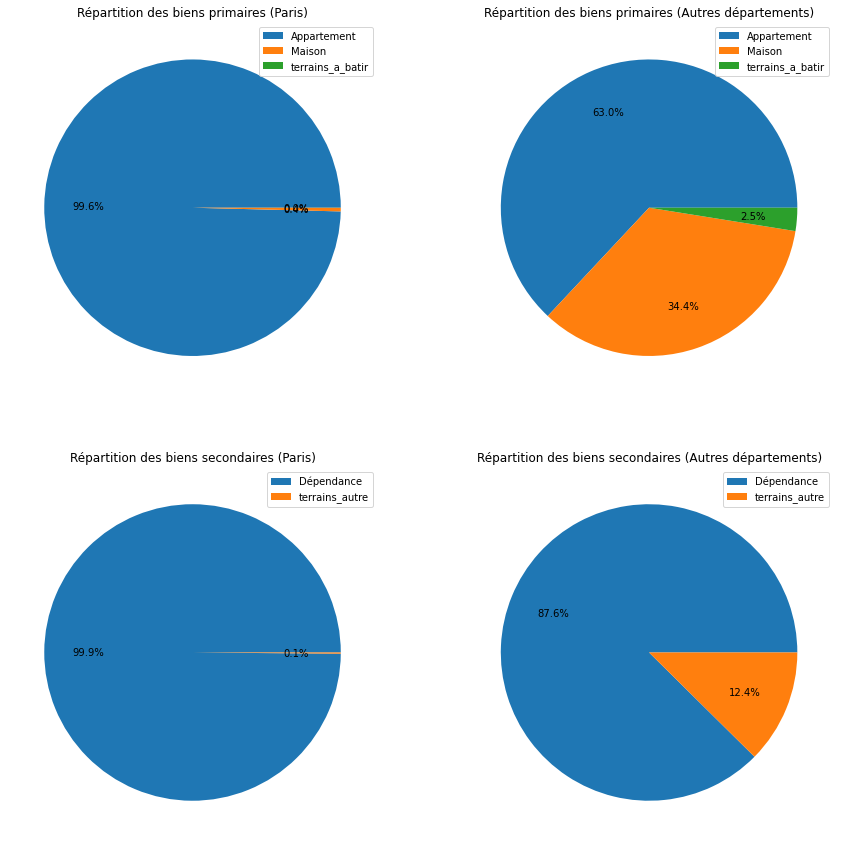

In [207]:
#Répartition des types de biens principaux:
tot_bien_prim75=pd.DataFrame(df_75[["Appartement", "Maison", "terrains_a_batir"]].apply(np.sum, axis = 0), columns=["Nombre"]).reset_index(drop=False).rename({'index' : 'Type'}, axis = 1)
tot_bien_primno75=pd.DataFrame(df_no75[["Appartement", "Maison", "terrains_a_batir"]].apply(np.sum, axis = 0), columns=["Nombre"]).reset_index(drop=False).rename({'index' : 'Type'}, axis = 1)

fig = plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.pie(tot_bien_prim75["Nombre"], 
        labels=tot_bien_prim75["Type"], 
        autopct = (lambda a: str(round(a, 1))+"%"), 
        pctdistance =0.7, 
        labeldistance = None)
plt.title("Répartition des biens primaires (Paris)")
plt.legend()

plt.subplot(2, 2, 2)
plt.pie(tot_bien_primno75["Nombre"], 
        labels=tot_bien_primno75["Type"], 
        autopct = (lambda a: str(round(a, 1))+"%"), 
        pctdistance =0.7, 
        labeldistance = None)
plt.title("Répartition des biens primaires (Autres départements)")
plt.legend()


#Répartition des types de biens secondaires:
tot_bien_sec75=pd.DataFrame(df_75[["Dépendance", "terrains_autre"]].apply(np.sum, axis = 0), columns=["Nombre"]).reset_index(drop=False).rename({'index' : 'Type'}, axis = 1)
tot_bien_secno75=pd.DataFrame(df_no75[["Dépendance", "terrains_autre"]].apply(np.sum, axis = 0), columns=["Nombre"]).reset_index(drop=False).rename({'index' : 'Type'}, axis = 1)

plt.subplot(2, 2, 3)
plt.pie(tot_bien_sec75["Nombre"], 
        labels=tot_bien_sec75["Type"], 
        autopct = (lambda a: str(round(a, 1))+"%"), 
        pctdistance =0.7, 
        labeldistance = None)
plt.title("Répartition des biens secondaires (Paris)")
plt.legend()

plt.subplot(2, 2, 4)
plt.pie(tot_bien_secno75["Nombre"], 
        labels=tot_bien_secno75["Type"], 
        autopct = (lambda a: str(round(a, 1))+"%"), 
        pctdistance =0.7, 
        labeldistance = None)
plt.title("Répartition des biens secondaires (Autres départements)")
plt.legend();

Nous remarquons qu'il y a beaucoup plus de biens de type maison, ainsi que plus de terrains secondaires, dans les autres départements que dans Paris. Cette donnée explique aussi peut être le taux d'erreur supérieur. 

Nous allons tenter d'entrainer un modèle dédié uniquement à Paris, pour voir si cela permettrait d'améliorer un peu les prédictions de cette zone spécifique. 

### Modèle de régression pour Paris:

In [212]:
#Préparation des données centrées sur Paris:
paris=num_df[num_df["code_departement"]==75]
X_trainP, X_testP, y_trainP, y_testP=preprocessing(paris, scaler)

#Entrainement d'un modèle dédié à Paris:
GBR_Paris=GradientBoostingRegressor(n_estimators=300, max_depth=5)
GBR_Paris.fit(X_trainP, y_trainP)
perf(GBR_Paris, X_trainP, X_testP, y_trainP, y_testP)

Score train:  0.8761357329155963
Score test:  0.8148660946469164


MAE train:  89558.30453418527
MAE test:  100153.35017623389


RMSE train:  153348.05306487108
RMSE test:  187156.56520144007


### Résultats du modèle:

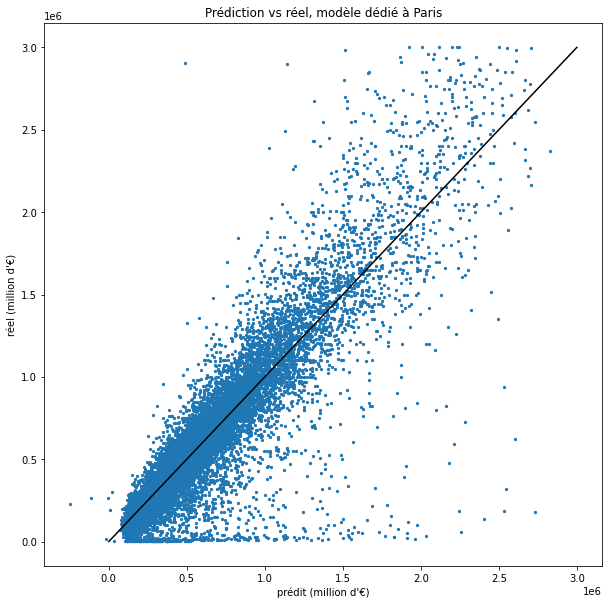

In [214]:
#Prédiction vs réel:
pred_testP = GBR_Paris.predict(X_testP)
plt.figure( figsize= (10, 10) )
plt.scatter(pred_testP, y_testP, s=5)
plt.plot([0, 3000000], [0, 3000000], c="black")
plt.xlabel("prédit (million d'€)")
plt.ylabel("réel (million d'€)")
plt.title("Prédiction vs réel, modèle dédié à Paris");

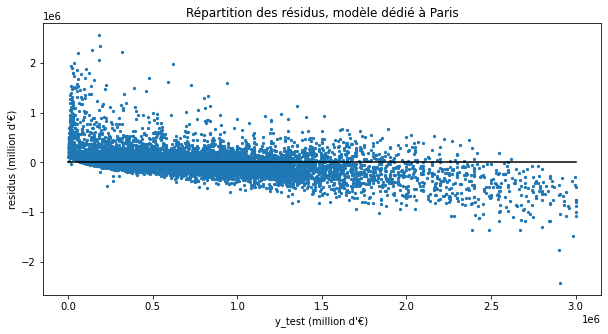

In [215]:
residusP=pred_testP-y_testP
plt.figure( figsize= (10, 5) )
plt.scatter(y_testP, residusP, s=5)
plt.plot([0, max(y_test)], [0, 0], c="black")
plt.xlabel("y_test (million d'€)")
plt.ylabel("residus (million d'€)")
plt.title("Répartition des résidus, modèle dédié à Paris");

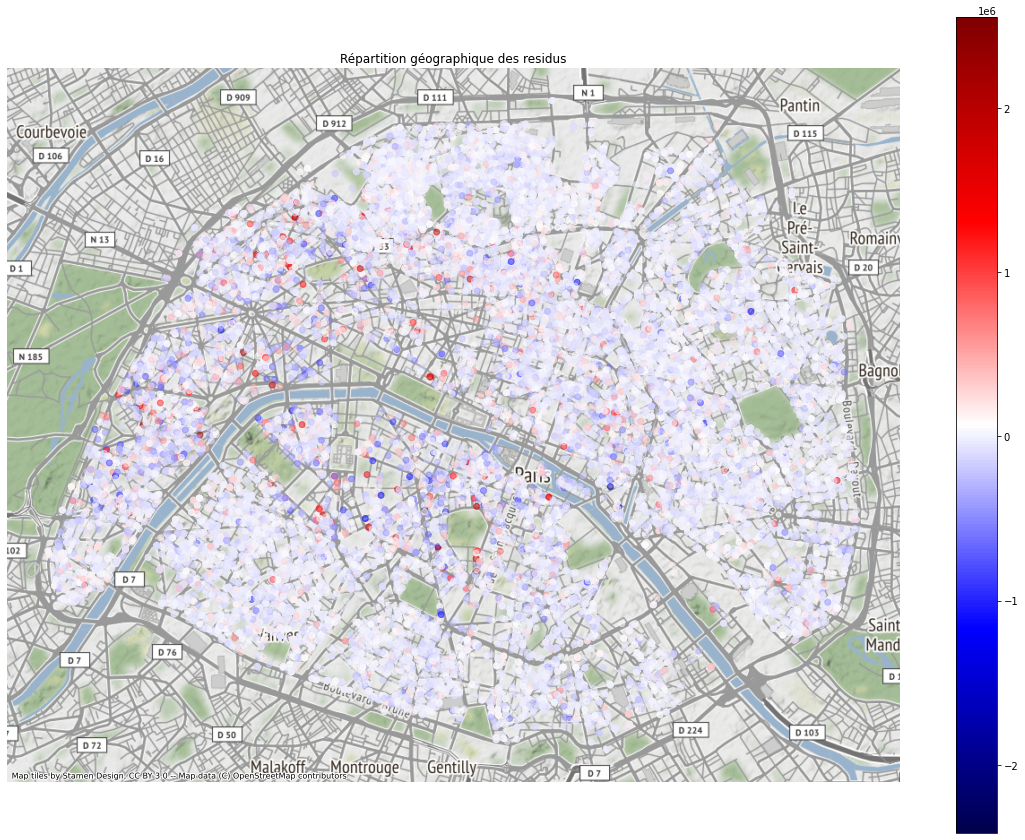

In [222]:
#Inversion de la standardisation ppour récupérer les coordonnées géo
revX_testP=pd.DataFrame(scaler.inverse_transform(X_testP), columns=X_testP.columns)
revX_testP["residus"]=residusP.reset_index(drop=True)

#Création d'un geodataframe avec les coordonnées géographiques
geoXtestP=gpd.GeoDataFrame(revX_testP[["residus", "longitude", "latitude"]], geometry=gpd.points_from_xy(revX_testP["longitude"], revX_testP["latitude"])).drop(["longitude", "latitude"], axis=1)

#Conversion du format EPSG
geoXtestP.crs = "EPSG:4326"
geoXtestP_wm=geoXtestP.to_crs(epsg=3857)

#Répartition des residus dans la région Ile de France:
fig, ax = plt.subplots(figsize=(20, 15))
geoXtestP_wm.plot(alpha=0.5, column="residus", ax=ax, legend=True, cmap="seismic")
plt.title("Répartition géographique des residus")
plt.axis('off')
cx.add_basemap(ax)

En comparant les erreurs du modèle global et celles du modèle dédié à Paris, nous ne constatons aucune amélioration notable. 

# Conclusions:

Nous avons réussi à obtenir un modèle de régression permettant d'obtenir une estimation de prix avec une précision d'environ 84% et une erreur moyenne absolue d'environ 63 000€ sur des prix de vente jusqu'à 3 000 000€. Cependant, notre modèle semble plus efficace sur des estimations de prix entre 500 000€ et 1 000 000€. Nous pourrions donc restreindre l'utilisation de ce modèle à cette tranche de prix. 

Nous notons également que notre modèle prend encore mal en compte l'impact de la localisation, en sur-estimant les prix bas et en sous-estimant les prix élevés. Les ventes dans la zone de Paris étant globalement plus élevées que dans le reste de la région, le modèle se trouve peu performant dans cette zone précise.

Enfin, le manque de variables explicatives dans notre jeu de données sur les caractéristiques des biens vendus comme le nombre de chambres, de salles de bain ou encore la vétusté du bien explique probablement en partie la forte dispertion des résidus. 

Des solutions envisageables pour améliorer le modèle, notamment dans sa prise en compte de la notion de localisation, pourraient être d'utiliser des algorithmes de régression pondérées géographiquement (GWR). Cette solution ne sera néanmoins pas testée dans ce projet par manque de temps.